<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/Tutorials/Intro_to_GANs_Failed_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANs with MNIST

Previous attempt did not work, re-trying with some modifications.
- No Pytorch Lightning and building everything from the ground up

In [ ]:
# import libraries

import torch
import torch.nn as nn
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

## Get Data

In [ ]:
# Create transform

transform = v2.Compose([v2.PILToTensor(),
                        v2.ToDtype(torch.float),
                        v2.Resize(64, antialias=True),
                        v2.Normalize((0.5, ), (0.5, ))])

In [ ]:
# Get the data

train_dataset = MNIST(root = "data/",
                      train = True,
                      transform = transform,
                      download=True)

test_dataset = MNIST(root = "data/",
                     train = False,
                     transform = transform,
                     download=True)

Text(0.5, 1.0, '5')

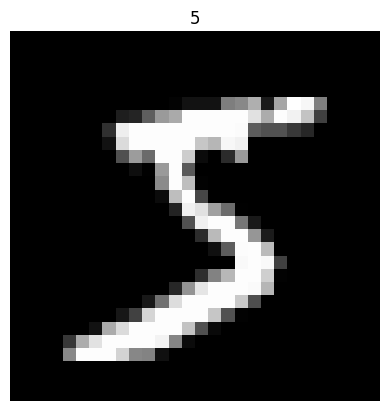

In [ ]:
# View a single image

img = train_dataset.data[0]
target = train_dataset.targets[0]

plt.imshow(img, cmap="gray")
plt.axis(False)
plt.title(target.item())

In [ ]:
# Create dataloaders

BATCH_SIZE = 128
NUM_WORKERS = 1

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

In [ ]:
len(train_dataloader), len(test_dataloader)

(469, 78)

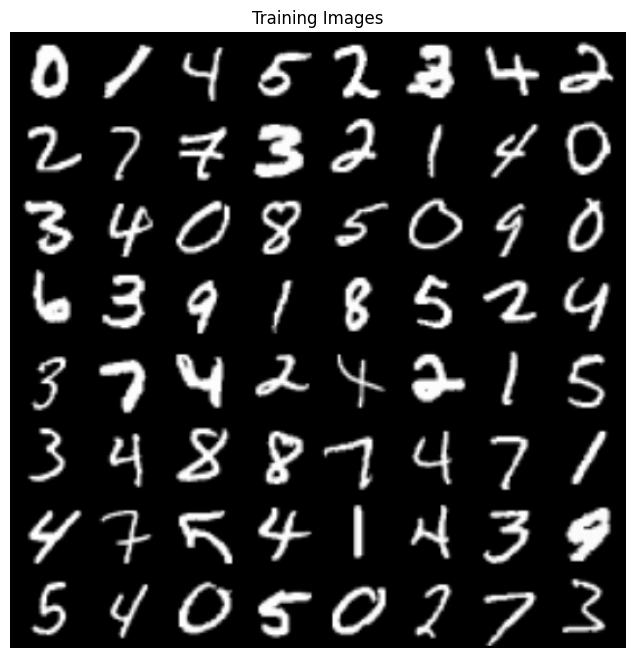

In [ ]:
import torchvision.utils as vutils

batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")

plt.imshow(np.transpose(vutils.make_grid(batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Model Setup

Functions like a normal image classification CNN except the output is a single class
 - Binary Classification

In [ ]:
# Discriminator (Simple CNN) - expects inputs to have 28x28 heightxwidth

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(num_features=64),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),
        nn.MaxPool2d(1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True)
    )

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=7 * 7 * 128, out_features=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.flatten(x)
    x = self.linear(x)
    return self.sigmoid(x)

In [ ]:
# Test the Discriminator

d = Discriminator()
t = torch.randn(128, 1, 28,28)

out = d(t)
out[:5].view(-1)

tensor([0.3961, 0.3903, 0.5542, 0.6006, 0.5008], grad_fn=<ViewBackward0>)

In [ ]:
IMAGE_CHANNEL=1
D_HIDDEN=64

In [ ]:
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [ ]:
d2 = Discriminator2()
t = torch.randn(128, 1, 64,64)

out = d2(t)
out[:5]

tensor([0.4760, 0.5415, 0.4287, 0.5074, 0.4458], grad_fn=<SliceBackward0>)

General Process
- Take Latent Dimension and upsample increasing the number of planes
- Reduce the number of planes while upsampling
- Finish with the number of image channels


When can choose what the height and width of the input looks like when generating the random noise which will be used as input into the generator
- Just ensure the kernel size + stride + padding of the `ConvTranspose2d` result in a 28 x 28 image
- In our case, we are choosing our input noise to be `[batch_size, latent_dim, 1, 1]` in shape

In [ ]:
# Generator - Upsamples images

class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.classifier = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.classifier(x)
    return x

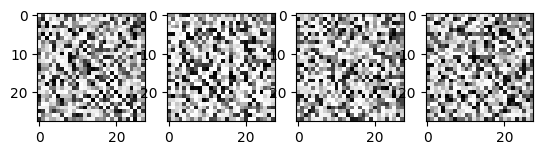

In [ ]:
rand_t = torch.randn(4, 100, 1, 1)
g = Generator(100)
out = g(rand_t)

for i, img in enumerate(out):
  img = img.squeeze()
  plt.subplot(1, 4, i+1)
  plt.imshow(img.detach().cpu(), cmap="gray")

In [ ]:
Z_DIM = 100
G_HIDDEN = 64

In [ ]:
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

torch.Size([4, 1, 64, 64])


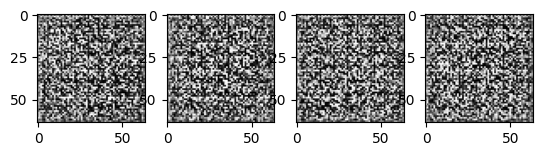

In [ ]:
rand_t = torch.randn(4, 100, 1, 1)
g = Generator2()
out = g(rand_t)

print(out.shape)

for i, img in enumerate(out):
  img = img.squeeze()
  plt.subplot(1, 4, i+1)
  plt.imshow(img.detach().cpu(), cmap="gray")

Some Intersting Reminders

- Why we detach the fake images when training the generator [here](https://discuss.pytorch.org/t/couldnt-understand-how-detach-is-changing-the-generator-working/84637https://)

In [ ]:
# Train Discriminator

def train_step(generator, discriminator, d_opt, g_opt, loss_fn, dataloader, device):

  g_loss_lst = []
  d_loss_lst =  []

  for i, data in tqdm(enumerate(dataloader), desc="In Epoch"):

    ############################# Train Discriminator ###################################
    d_opt.zero_grad()

    # Real Imgs
    real_imgs = data[0].to(device)
    y = torch.ones(real_imgs.size(0), device=device)

    # Forward Pass
    y_preds_real = discriminator(real_imgs).view(-1) # Match dimensions of y
    loss_real = loss_fn(y_preds_real, y)
    loss_real.backward()

    # Fake Imgs
    z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    fake_imgs = generator(z).detach() # Don't want any graidents from fake_imgs to be propogated back to the generator since we are training discriminator
    y = torch.zeros(fake_imgs.size(0), device=device)

    #Forward pass
    y_preds_fake = discriminator(fake_imgs).view(-1)
    loss_fake = loss_fn(y_preds_fake, y)
    loss_fake.backward()

    d_loss_lst.append((loss_fake + loss_real).item())
    d_opt.step()

    ####################### Train Generator #############################################

    g_opt.zero_grad()
    fake_imgs = generator(z)
    y = torch.ones(fake_imgs.size(0), device=device)

    # Forward pass
    y_preds = discriminator(fake_imgs).view(-1)
    g_loss = loss_fn(y_preds,  y)
    g_loss.backward()

    g_loss_lst.append(g_loss.item())
    g_opt.step()

    if i % 50 == 0:
      print(f"G Loss : {g_loss} | D Loss : {loss_fake + loss_real}")


  valid_imgs = generator(z).detach().cpu()
  return g_loss_lst, d_loss_lst, valid_imgs




## Train Model

The default weights provided easily lead to saturation
- Saturation is a state in which neuron predominately outputs values close to the asymptotic ends of bounded activation function
- This is the vanishing/exploding gradients problem

From the DCGAN paper the authors specify the following wieghts
- Randomly initialized from normal distribution with mean 0 and standard deviation 0.02

In [ ]:
# Initalize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [ ]:
discriminator = Discriminator2()
generator = Generator2()

In [ ]:
generator.apply(weights_init)
print(generator)
discriminator.apply(weights_init)
print(discriminator)

Generator2(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

Note on what beta values are [here](https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html#:~:text=%CE%B21%20is%20the%20exponential%20decay,displayed%20in%20the%20image%20below.&text=%CE%B22%20is%20the%20exponential%20decay,called%20the%20second%2Dmoment%20estimates.)
- Essentially the first and second moments

In [ ]:
# Setup optimizer and loss function

g_opt = torch.optim.Adam(params=generator.parameters(),
                         lr = 0.001,
                         betas=(0.5, 0.999))
d_opt = torch.optim.Adam(params=discriminator.parameters(),
                         lr=0.0001,
                         betas=(0.5,0.999))

In [ ]:
# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
discriminator.to(device)
generator.to(device)

cuda


Generator2(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
loss_fn = torch.nn.BCELoss()

Starting Training


Training Model:   0%|          | 0/10 [00:00<?, ?it/s]

In Epoch: 0it [00:00, ?it/s]

G Loss : 1.4263399839401245 | D Loss : 1.2597424983978271
G Loss : 0.13974957168102264 | D Loss : 5.692205429077148
G Loss : 0.10955873131752014 | D Loss : 5.921981334686279
G Loss : 0.22885927557945251 | D Loss : 5.661149024963379
G Loss : 0.20381267368793488 | D Loss : 5.609320640563965
G Loss : 0.32713937759399414 | D Loss : 5.550336837768555
G Loss : 0.934553861618042 | D Loss : 2.7419164180755615
G Loss : 0.2121490240097046 | D Loss : 4.339441299438477
G Loss : 3.4947171211242676 | D Loss : 1.49607515335083
G Loss : 1.5592365264892578 | D Loss : 2.064873218536377
Epoch 0 | G Loss : 0.8978041410446167 | D Loss : 4.774223327636719


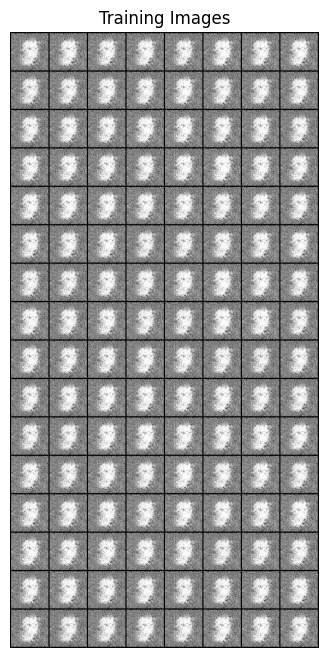

In Epoch: 0it [00:00, ?it/s]

G Loss : 0.6859002113342285 | D Loss : 4.780986785888672
G Loss : 1.099635124206543 | D Loss : 2.863859176635742
G Loss : 1.2745037078857422 | D Loss : 2.1696557998657227
G Loss : 1.6279748678207397 | D Loss : 0.9858419895172119
G Loss : 1.4196555614471436 | D Loss : 1.1651802062988281
G Loss : 3.764434576034546 | D Loss : 0.2894701063632965
G Loss : 2.2865700721740723 | D Loss : 0.5027326345443726
G Loss : 2.1974596977233887 | D Loss : 0.44906339049339294
G Loss : 2.7032620906829834 | D Loss : 0.24070002138614655
G Loss : 2.4878287315368652 | D Loss : 0.23592035472393036


In [ ]:
from tqdm.auto import tqdm
G_losses = []
D_losses = []
EPOCHS = 10


print("Starting Training")
for epoch in  tqdm(range(EPOCHS), desc="Training Model"):
  g_loss, d_loss, imgs = train_step(generator=generator, discriminator=discriminator, d_opt=d_opt, g_opt=g_opt, loss_fn=loss_fn, dataloader=train_dataloader, device=device)

  G_losses.extend(g_loss)
  D_losses.extend(d_loss)
  print(f"Epoch {epoch} | G Loss : {g_loss[-1]} | D Loss : {d_loss[-1]}")

  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(imgs, padding=2, normalize=True).cpu(),(1,2,0)))
  plt.show()



In [ ]:
plt.plot(d_loss)
